In [1]:
# importa os pacotes necessários
import numpy as np
import os, cv2, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA,IncrementalPCA
from skimage.measure import block_reduce
from tqdm import tqdm
import os
import warnings
import pickle
warnings.filterwarnings("ignore")
%matplotlib inline 

# Lendo imagem

(32, 32, 3)


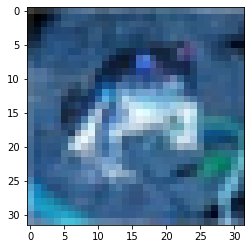

In [2]:
#funções de leitura das imagens
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return img#cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
img = read_image('kaggle/train/1.png')
print(img.shape)
plt.imshow(img)

# Descritor 1 - Histograma

((512,), (512,))

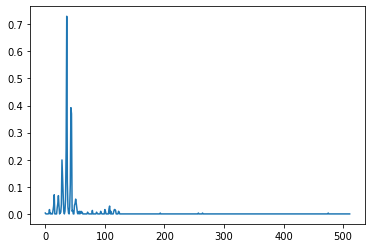

In [3]:
def extract_color_histogram(image, bins=(8, 8, 8)):     
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    #image = cv2.imread(image_file)        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    # the flattened histogram as the feature vector
    hist = hist.flatten()
    
    #columns name
    columns = np.array(['hist_%03d'%(i+1) for i in range(len(hist))])
    
    return hist, columns
hist, cols1 = extract_color_histogram(img)
plt.plot(hist)
hist.shape, cols1.shape

# Descritor 2 - Feature Vector

((3072,), (3072,))

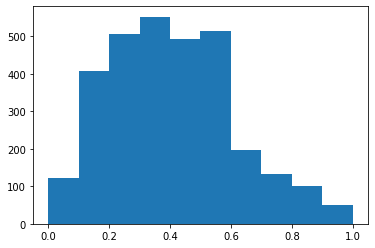

In [4]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    if img.shape[:2] != size:
        fvet = cv2.resize(image, size).flatten()
    else:
        fvet = image.flatten()
    fvet = fvet/255
    
    #columns name
    columns = np.array(['fvet_%03d'%(i+1) for i in range(len(fvet))])
    
    return fvet.astype('float32'),columns

fvet, cols2 = image_to_feature_vector(img)
plt.hist(fvet)
fvet.shape, cols2.shape

# Descritor 3 - Hu Moments

In [5]:
def hu_moments(image, size=(32, 32)):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hmom = cv2.HuMoments(cv2.moments(img_gray)).flatten().astype('float32')
    cols = np.array(['humom_1','humom_2','humom_3','humom_4','humom_5','humom_6','humom_7'])
    return hmom,cols
hmom, cols3 = hu_moments(img)
print(hmom)
hmom.shape, cols3.shape

[ 1.3759799e-03  8.5581897e-09  1.9961354e-11  5.1247491e-12
  4.6797485e-23 -2.6552654e-16  2.2285095e-23]


((7,), (7,))

# Descritor 4 - Gabor Filters
https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gabor

In [6]:
from skimage.filters import gabor,gabor_kernel
from scipy import ndimage as ndi

In [7]:
def gabor_kernels():
    kernels = list()
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = gabor_kernel(frequency, theta=theta,
                                    sigma_x=sigma, sigma_y=sigma)
                kernels.append(np.real(kernel)) 
    return kernels

In [8]:
kernels = gabor_kernels()
print(len(kernels))

16


In [9]:
filters_cols = None
def filters(img, kernels):
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs = list()
    for kernel in kernels:
        fl_img = ndi.convolve(img_gray, kernel, mode='reflect')
        fl_img = block_reduce(fl_img, (2,2), np.max)#max pooling
        imgs.append(fl_img)
        
    fl_desc = np.array(imgs).flatten()
    
    #columns name, carrega se existir para economizar tempo
    global filters_cols
    if filters_cols is None:
        filters_cols = np.array(['filter_%05d'%(i+1) for i in range(len(fl_desc))])
    
    return fl_desc,filters_cols


In [10]:
%%time
gbor, cols4 = filters(img,kernels)
print(gbor.shape)

(4096,)
CPU times: user 27.2 ms, sys: 0 ns, total: 27.2 ms
Wall time: 26.9 ms


# Junta Descritores

In [11]:
#Cria um dataframe com uma linha dos descritores
def junta_descritores(descritores, colunas):
    df = pd.DataFrame()
    dfs = list()
    for d,c in zip(descritores, colunas):
        #dff = pd.DataFrame([d], columns=c,dtype=d.dtype)
        dff = pd.Series(d, index=c,dtype=d.dtype)
        dfs.append(dff)
    df = pd.concat(dfs).to_frame().T
    return df

In [12]:
df = junta_descritores([hist,fvet,hmom,gbor],[cols1,cols2,cols3,cols4])
print(df.shape)
df

(1, 7687)


,hist_001,hist_002,hist_003,hist_004,hist_005,hist_006,hist_007,hist_008,hist_009,hist_010,...,filter_04087,filter_04088,filter_04089,filter_04090,filter_04091,filter_04092,filter_04093,filter_04094,filter_04095,filter_04096
0,0.003214,0.0,0.0,0.0,0.0,0.0,0.003214,0.016068,0.0,0.003214,...,0.0,1.0,255.0,255.0,1.0,255.0,255.0,0.0,0.0,0.0


# Pipeline

In [13]:
# retorna uma serie com os descritores
def pipeline1(file_path,kernels):

    img = read_image(file_path)
    
    #descritores
    hist, cols1 = extract_color_histogram(img)
    fvet, cols2 = image_to_feature_vector(img)
    hmom, cols3 = hu_moments(img)
    gbor, cols4 = filters(img,kernels)

    #...
    
    #junta
    df_row = junta_descritores([hist,fvet,hmom,gbor],[cols1,cols2,cols3,cols4])
    return df_row

In [14]:
def run_pipeline(n_images = 50000): 
    
    file_csv_path = os.path.join('kaggle',"data")+'.csv'
    
    kernels = gabor_kernels()
    
    #para cada imagem 
    first = True
    with open(file_csv_path, 'a') as f:
        for i in tqdm(range(1,n_images+1)):

            #adiciona linha na tabela
            file_path = os.path.join(os.path.join('kaggle',"train"),str(i))+'.png'
            df_row = pipeline1(file_path,kernels)
            
            #salva
            if first:
                df_row.to_csv(f,index=False) #salva tmb o nome das colunas
                minimos = df_row.copy()
                maximos = df_row.copy()
            else:
                df_row.to_csv(f,mode = 'a',header=False,index=False)
                minimos = np.minimum(minimos,df_row.min())
                maximos = np.maximum(maximos,df_row.max())
            first = False
        
                
    return file_csv_path,maximos,minimos

In [15]:
%%time
file_path,maximos,minimos = run_pipeline()

100%|██████████| 50000/50000 [40:52<00:00, 20.39it/s]  

CPU times: user 37min 4s, sys: 24 s, total: 37min 28s
Wall time: 40min 52s


## Ajusta e Normaliza

In [16]:
chunksize = 2500

In [17]:
file_path = os.path.join('kaggle',"data")+'.csv'
df = pd.read_csv(file_path,nrows=1)
dtypes = dict()
for c in df.columns:
    if c[:6]=='filter':
        dtypes[c] = np.uint8 
    else:
        dtypes[c] = np.float32 

In [18]:
#Normaliza 
reader = pd.read_csv('kaggle/data.csv',
                     chunksize = chunksize,
                     dtype = dtypes)
first = True
with tqdm(total=50000) as pbar:
    with open("kaggle/data_norm.csv", 'a') as f:
        for chunk in reader:
            df = (chunk-minimos.values)/(maximos.values-minimos.values)
            if first:
                df.astype('float32').to_csv(f,index=False) #salva tmb o nome das colunas
            else:
                df.astype('float32').to_csv(f,mode = 'a',header=False,index=False)
            first = False
            pbar.update(chunksize)

100%|██████████| 50000/50000 [14:29<00:00, 57.47it/s]


# PCA
lendo os dados em chunks pois o dataframe é muito grande

In [19]:
n_components = 2500

In [20]:
#fit 
reader = pd.read_csv('kaggle/data_norm.csv',
                     chunksize = chunksize)
pca = IncrementalPCA(n_components=n_components)
with tqdm(total=50000) as pbar:
    for chunk in reader:
        pca.partial_fit(chunk)
        pbar.update(chunksize)

100%|██████████| 50000/50000 [1:23:48<00:00,  9.94it/s]


In [21]:
#salva pca
with open('pca.pkl','wb') as f:
    pickle.dump(pca,f)
#with open('pca.pkl','rb') as f:
#    pca = pickle.load(f)

In [22]:
sum(pca.explained_variance_ratio_)

0.9946063268026906

In [24]:
chunksize = 500
#transform
reader = pd.read_csv('kaggle/data_norm.csv',
                     chunksize = chunksize)

with tqdm(total=50000) as pbar:
    with open("kaggle/data_pca.csv", 'a') as f:
        first = True
        for chunk in reader:
            principalComponents = pca.transform(chunk)
            
            #para dataframe
            n_components = principalComponents.shape[1] 
            df_pca = pd.DataFrame(data = principalComponents,
                      columns = ['comp_%04d'%i for i in range(n_components)]).astype('float32')
            
            if first:
                df_pca.to_csv(f,index=False) #salva tmb o nome das colunas
            else:
                df_pca.to_csv(f,mode = 'a',header=False,index=False)
            first = False
            pbar.update(chunksize)

100%|██████████| 50000/50000 [09:33<00:00, 87.22it/s] 


# Escolha do número de componentes do PCA

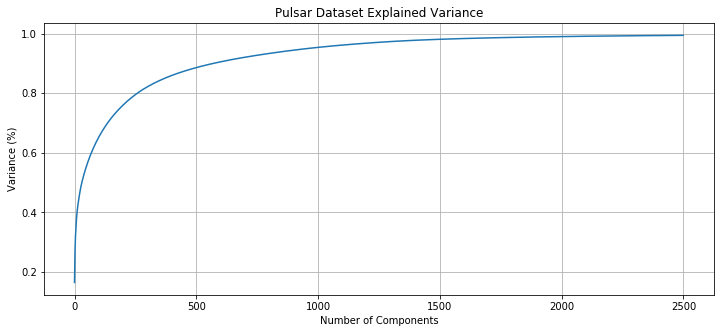

In [26]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(12,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.grid()
plt.show()

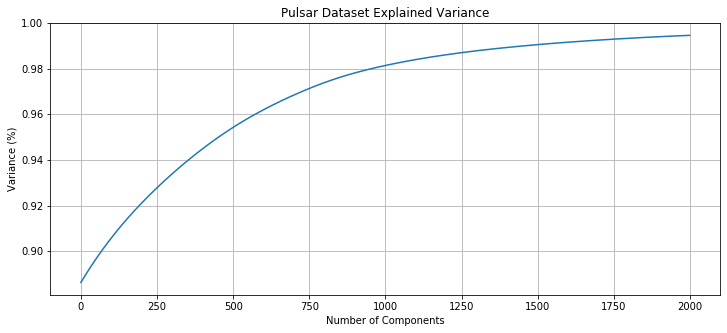

In [29]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(12,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)[500:])
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.grid()
plt.show()